In [1]:
#from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne

#from lasagne.regularization import l2

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

def build_custom_mlp(input_var=None, DEPTH=2, WIDTH=800, DROP_INPUT=.2,
                     DROP_HIDDEN=.5):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    if DROP_INPUT:
        network = lasagne.layers.dropout(network, p=DROP_INPUT)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.sigmoid
    for _ in range(DEPTH):
        network = lasagne.layers.DenseLayer(
                network, WIDTH, nonlinearity=nonlin)
        if DROP_HIDDEN:
            network = lasagne.layers.dropout(network, p=DROP_HIDDEN)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 10, nonlinearity=softmax)
    return network

def build_hidden_fc(input_var=None, WIDTH=100):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    in_layer = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    #if DROP_INput:
    #    network = lasagne.layers.dropout(network, p=DROP_INput)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.sigmoid
    #for _ in range(DEPTH):
    layer_1 = lasagne.layers.DenseLayer(in_layer, WIDTH, nonlinearity=nonlin)
    layer_2 = lasagne.layers.DenseLayer(layer_1, WIDTH, nonlinearity=nonlin)
    #    if DROP_HIDden:
    #        network = lasagne.layers.dropout(network, p=DROP_HIDden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(layer_2, 10, nonlinearity=softmax)
    return network
    #, layer_1, layer_2

def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # 2 Convolutional layers with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 64 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(network, num_units=200,
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.DenseLayer(network, num_units=200,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(network, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

# Prepare Theano variables for inputs and targets
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

# Create neural network model (depending on first command line parameter)
print("Building model and compiling functions...")

NUM_EPOCHS=500
DEPTH=2
WIDTH=100
DROP_IN=0.2
DROP_HID=0.5
#network = build_custom_mlp(input_var,int(DEPTH),int(WIDTH),float(DROP_IN), float(DROP_HID))
network = build_hidden_fc(input_var, int(WIDTH))

#if hidden_layers==0:
# DEPTH=2
# WIDTH=800
# DROP_IN=0.2
# DROP_HID=0.5
# network = build_custom_mlp(input_var, int(DEPTH), int(WIDTH),
#                             float(DROP_IN), float(DROP_HID))
    #lambda_network=1e-4
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    # prediction = lasagne.layers.get_output(network)
    # loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    #l2_penalty=lasagne.regularization.regularize_layer_params(
                                                    #network,l2)*lambda_network
    #loss=loss+l2_penalty/10
    # loss = loss.mean()
    #myfile=open('FSG_results.txt','a')
    #myfile.write('Model: FC10('+str(lambda_network)+')'+'\n')
# elif hidden_layers!=0:
#     WIDTH=100
#     network=build_hidden_fc(input_var,int(WIDTH))
    #, layer_1, layer_2
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    # prediction = lasagne.layers.get_output(network)
    # loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    #layers={layer_1:1e-7,layer_2:1e-7,network:1e-7}
    #l2_penalty=lasagne.regularization.regularize_layer_params_weighted(layers,
                                                                            #l2)
    #loss=loss
    #+l2_penalty
    # loss = loss.mean()
    # myfile=open('FSG_results.txt','a')
    # myfile.write('Model: FC10_'+str(hidden_layers)+'_'+str(WIDTH)+'\n')

#network=build_cnn(input_var)

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss=loss.mean()
# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

eval_fn=theano.function([input_var,target_var],loss)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

predict_fn=theano.function([input_var],T.argmax(test_prediction, axis=1))

req_gradient=T.grad(loss,input_var)
grad_function=theano.function([input_var,target_var],req_gradient)

model_exist_flag=1

script_dir=os.getcwd()

if model_exist_flag==1:
#    And load them again later on like this:
    rel_path_m="Models/"
    abs_path_m=os.path.join(script_dir,rel_path_m)
    with np.load(abs_path_m+'model_FC10_'+str(DEPTH)+'_'+str(WIDTH)+'_.npz') as f:
            param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # with np.load(abs_path_m+'model_cnn_9_layers_papernot.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)
# elif model_exist_flag==1 and hidden_layers!=0:
#     with np.load('model_FC10_'+str(hidden_layers)+'_'+str(WIDTH)+'.npz') as f:
#         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
#     lasagne.layers.set_all_param_values(network, param_values)
elif model_exist_flag==0:
        # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(NUM_EPOCHS):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 1, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1
        #print("{}".format(inputs))
        #print("{}".format(targets+1))

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, NUM_EPOCHS, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    rel_path_m="Models/"
    abs_path_m=os.path.join(script_dir,rel_path_m)

    np.savez('model_FC10_'+str(DEPTH)+'_'+str(WIDTH)+'_drop.npz',
            *lasagne.layers.get_all_param_values(network))

    # np.savez(abs_path_m+'model_cnn_9_layers_papernot.npz',
    #         *lasagne.layers.get_all_param_values(network))
# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

avg_test_acc=test_acc/test_batches*100

# Writing the test results out to a file
# rel_path_o="Output_data/"
# abs_path_o=os.path.join(script_dir,rel_path_o)
# myfile=open(abs_path_o+'MNIST_test_perform.txt','a')
# myfile.write('Model: FC10_'+str(DEPTH)+'_'+str(WIDTH)+
#                 '_drop'+'\n')
# #myfile.write('Model: model_cnn_9_layers_papernot'+'\n')
# myfile.write("reduced_dim: "+"N.A."+"\n"+"Epochs: "
#             +str(NUM_EPOCHS)+"\n"+"Test accuracy: "
#             +str(avg_test_acc)+"\n")
# myfile.write("#####################################################"+
#                 "####"+"\n")
# myfile.close()

# if hidden_layers==0:
#     np.savez('model_FC10('+str(lambda_network)+')'+'.npz',
#                 *lasagne.layers.get_all_param_values(network))
# elif hidden_layers!=0:
#     np.savez('model_FC10_'+str(hidden_layers)+'_'+str(WIDTH)+'.npz',
#             *lasagne.layers.get_all_param_values(network))

#Computing adversarial examples using fast sign gradient method
# req_gradient=T.grad(loss,input_var)
# grad_function=theano.function([input_var,target_var],req_gradient)
confidence=theano.function([input_var],test_prediction)
#from matplotlib import pyplot as plt
#%matplotlib inline
rel_path_o="Output_data/"
abs_path_o=os.path.join(script_dir,rel_path_o)
# Variables and loop for finding adversarial examples from traning set
# plotfile=open(abs_path_o+'PCA_attack_MNIST_data_hidden_'+str(DEPTH)+'_'
#                  +str(WIDTH)+'_'+'.txt','a')
X_train=X_train.reshape((50000,784))

# rd=100

# from sklearn.decomposition import PCA
# PCA_in_train=X_train.reshape(50000,784)
# PCA_in_val=X_val.reshape(10000,784)
# PCA_in_test=X_test.reshape(10000,784)

# pca=PCA(n_components=rd)
# pca_train=pca.fit(PCA_in_train)

# #Transforming the training, validation and test data
# X_train_dr=pca.transform(PCA_in_train).reshape((50000,rd))

# PCA_vectors=pca.components_
# PCA_vectors=np.transpose(np.array(PCA_vectors))
# PCA_abs=np.absolute(PCA_vectors)

# scores_abs=np.zeros(784)
# for i in range(784):
#     for j in range(100):
#         scores_abs[i]=scores_abs[i]+np.sum(X_train[:,i]*PCA_abs[i,j])

# top_features=np.argsort(scores_abs)[::-1][:40]

# zero_array=np.zeros((50000,784))

# for i in range(50000):
#     np.put(zero_array[i,:],top_features,1)

# adv_x=X_train+1.0*zero_array

/Users/arjunbhagoji/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Loading data...
Building model and compiling functions...
Final results:
  test loss:			0.073418
  test accuracy:		97.71 %


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
count_tot=0.0
count_wrong=0.0
conf_wrong=0.0
count_abs_wrong=0.0
conf_abs=0.0
count_adv=0.0
conf_adv=0.0
count_correct=0.0
for DEV_MAG_ORIG in np.linspace(0.15,0.15,1):
    for i in range(10000):
        input_curr=(X_test[i]).reshape((1,1,28,28))
        y_curr=y_test[i].reshape((1,))
        ini_class=predict_fn(input_curr)
        delta_x_orig=grad_function(input_curr,y_curr)
        # Sign of gradient
        delta_x_sign_orig=np.sign(delta_x_orig)
        #Perturbed image
        x_adv=input_curr+DEV_MAG_ORIG*delta_x_sign_orig
        if y_curr==predict_fn(input_curr):
            count_correct=count_correct+1
        prediction_curr=predict_fn(x_adv)
        if prediction_curr!=predict_fn(input_curr):
            count_wrong=count_wrong+1
            conf_wrong=conf_wrong+confidence(x_adv)[0][prediction_curr[0]]
        if prediction_curr!=y_curr and y_curr==predict_fn(input_curr):
            count_adv=count_adv+1
            conf_adv=conf_adv+confidence(x_adv)[0][prediction_curr[0]]
#             fig=plt.imshow((x_adv.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
#             plt.savefig('MNIST_NN_'+str(15)+'_'+str(ini_class)+'_'+str(prediction_curr[0])+'.png',bbox_inches='tight')
#         fig=plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
#         plt.savefig('MNIST_SVM_'+str(ini_class)+'.png',bbox_inches='tight')
        if prediction_curr!=y_curr:
            count_abs_wrong=count_abs_wrong+1
            conf_abs=conf_abs+confidence(x_adv)[0][prediction_curr[0]]
        count_tot=count_tot+1
    print count_wrong/10000.0, count_adv/count_correct, count_abs_wrong/10000.0
    print conf_wrong/10000.0, conf_adv/count_correct, conf_abs/10000.0

0.9758 0.995394534848 0.9955
0.902242496918 0.92087229994 0.921467085372


In [7]:
count_correct

9771.0

In [4]:
count_tot=0.0
count_wrong=0.0
conf_wrong=0.0
count_abs_wrong=0.0
conf_abs=0.0
count_adv=0.0
conf_adv=0.0
DEV_MAG=2.0
for i in range(50000):
    input_curr=(X_train[i]).reshape((1,1,28,28))
    y_curr=y_train[i].reshape((1,))
    ini_class=predict_fn(input_curr)
    delta_x=grad_function(input_curr,y_curr)
#     delta_x=delta_x/np.linalg.norm((delta_x))
#     delta_x=delta_x.reshape((1,1,28,28))
    # Sign of gradient
    delta_x_sign=np.sign(delta_x).reshape((784))
    delta_x_sign=delta_x_sign/np.linalg.norm((delta_x_sign))
    delta_x_sign=delta_x_sign.reshape((1,1,28,28))
    #Perturbed image
    x_adv=input_curr+DEV_MAG*delta_x_sign
    #x_adv=(x_ini-1.0*(clf.coef_[ini_class[0],:]/(np.linalg.norm(clf.coef_[ini_class[0],:])))).reshape((1,784))
    #x_adv=adv_x[i,:].reshape((1,1,28,28))
    prediction_curr=predict_fn(x_adv)
    if prediction_curr!=predict_fn(input_curr):
        count_wrong=count_wrong+1
        conf_wrong=conf_wrong+confidence(x_adv)[0][prediction_curr[0]]
    if prediction_curr!=y_curr and y_curr==predict_fn(input_curr):
        count_adv=count_adv+1
        conf_adv=conf_adv+confidence(x_adv)[0][prediction_curr[0]]
    if prediction_curr!=y_curr:
        count_abs_wrong=count_abs_wrong+1
        conf_abs=conf_abs+confidence(x_adv)[0][prediction_curr[0]]
    count_tot=count_tot+1
print count_wrong/count_tot, count_adv/count_tot, count_abs_wrong/count_tot
print conf_wrong/count_wrong, conf_adv/count_adv, conf_abs/count_abs_wrong

0.88436 0.88392 0.88834
0.89262611763 0.892687689209 0.892913651274


In [9]:
delta_x_sign_mag=DEV_MAG*delta_x_sign.reshape((784))

In [10]:
delta_x_sign_orig_mag=DEV_MAG_ORIG*delta_x_sign_orig.reshape((784))

In [11]:
np.linalg.norm(delta_x_sign_mag)

2.0000000000000009

In [12]:
np.linalg.norm(delta_x_sign_orig_mag)

2.8000000000000012

In [28]:
delta_x=DEV_MAG*delta_x.reshape((784))

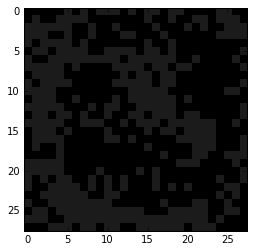

In [34]:
plt.imshow((delta_x_sign_mag.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

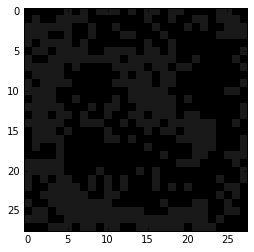

In [35]:
plt.imshow((delta_x_sign_orig_mag.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

In [5]:
import numpy as np
import matplotlib
import sys,os
import sys
import os
import time
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.regularization import l2
from sklearn.decomposition import PCA
import multiprocessing
import pandas as pd

# Defining required functions
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    script_dir=os.getcwd()
    rel_path="Input_data/"
    abs_path=os.path.join(script_dir,rel_path)
    X_train = load_mnist_images(abs_path+'train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels(abs_path+'train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images(abs_path+'t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels(abs_path+'t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def build_custom_mlp(input_var, depth, WIDTH, drop_input,
                     drop_hidden,rd):
    network = lasagne.layers.InputLayer(shape=(None, 1, rd),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.sigmoid
    for _ in range(depth):
        network = lasagne.layers.DenseLayer(
                network, WIDTH, nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 10, nonlinearity=softmax)
    return network

def build_cnn(input_var,rd):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, rd),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # 2 Convolutional layers with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv1DLayer(
            network, num_filters=32, filter_size=5,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    network = lasagne.layers.Conv1DLayer(
            network, num_filters=32, filter_size=5,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool1DLayer(network, pool_size=2)

    # Another convolution with 64 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv1DLayer(
            network, num_filters=64, filter_size=5,
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.Conv1DLayer(
            network, num_filters=64, filter_size=5,
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool1DLayer(network, pool_size=2)

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(network, num_units=200,
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.DenseLayer(network, num_units=200,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(network, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

def pca_main(rd):
    rd=rd
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test=load_dataset()
    #X_adv=np.genfromtxt(abs_path_o+'adv_examples_cnn_9_layers_papernot.txt',delimiter=',')
    #Reshaping for PCA function
    PCA_in_train=X_train.reshape(50000,784)
    PCA_in_val=X_val.reshape(10000,784)
    PCA_in_test=X_test.reshape(10000,784)
    # PCA_in_adv_train=X_adv[:500000,:].reshape(50000,784,10)
    # PCA_in_adv_test=X_adv[500000:,:].reshape(10000,784,10)

    print("Doing PCA over the training data")
    #Fitting the PCA model on training data
    pca=PCA(n_components=rd)
    pca_train=pca.fit(PCA_in_train)
    # X_adv_dr_train=np.zeros((50000,784,10))
    # X_adv_dr_test=np.zeros((10000,784,10))
    print ("Transforming the training, validation and test data")
    X_train_dr=pca.transform(PCA_in_train).reshape((50000,1,rd))
    X_test_dr=pca.transform(PCA_in_test).reshape((10000,1,rd))
    X_val_dr=pca.transform(PCA_in_val).reshape((10000,1,rd))
    # for i in range(1):
    #     X_adv_dr_train[:,:,i]=pca.transform(PCA_in_adv_train[:,:,i])
    #     X_adv_dr_test[:,:,i]=pca.transform(PCA_in_adv_test[:,:,i])


    ### Neural network learning with DR examples
    # Prepare Theano variables for inputs and targets
    input_var = T.tensor3('inputs')
    target_var = T.ivector('targets')
    # Create neural network model (depending on if hidden layers exist or not)
    print("Building model and compiling functions...")
    #depth, width, drop_in, drop_hid = model.split(':', 1)[1].split(',')
    network=build_custom_mlp(input_var, int(DEPTH), int(WIDTH),
                                float(DROP_IN), float(DROP_HID),rd)
    #network = build_cnn(input_var,rd)
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.1, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    eval_fn=theano.function([input_var,target_var],loss)

    # Compile a function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
    # Compile a function giving the network's prediction on any input
    predict_fn=theano.function([input_var],T.argmax(test_prediction, axis=1))
    #Probability vector for each output
    confidence=theano.function([input_var],test_prediction)

    # Loading the trained model
    rel_path_m="Models/"
    abs_path_m=os.path.join(script_dir,rel_path_m)
    with np.load(abs_path_m+'model_FC10_'+str(DEPTH)+'_'+str(WIDTH)+'_PCA_'+str(rd)+'_drop'+'.npz') as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
#     with np.load(abs_path_m+'model_cnn_9_layers_papernot'
#                                 +'_PCA_'+str(rd)+'.npz') as f:
#         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test_dr, y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    
    X_adv_dr=pca.transform(adv_x).reshape((50000,1,rd))
    count_tot=0.0
    count_wrong=0.0
    conf_wrong=0.0
    count_abs_wrong=0.0
    conf_abs=0.0
    count_adv=0.0
    conf_adv=0.0
    for i in range(50000):
        input_curr=(X_train_dr[i]).reshape((1,1,rd))
        y_curr=y_train[i].reshape((1,))
        ini_class=predict_fn(input_curr)
        #x_adv=(x_ini-1.0*(clf.coef_[ini_class[0],:]/(np.linalg.norm(clf.coef_[ini_class[0],:])))).reshape((1,784))
        x_adv=X_adv_dr[i].reshape((1,1,rd))
        prediction_curr=predict_fn(x_adv)
        if prediction_curr!=predict_fn(input_curr):
            count_wrong=count_wrong+1
            conf_wrong=conf_wrong+confidence(x_adv)[0][prediction_curr[0]]
        if prediction_curr!=y_curr and y_curr==predict_fn(input_curr):
            count_adv=count_adv+1
            conf_adv=conf_adv+confidence(x_adv)[0][prediction_curr[0]]
        if prediction_curr!=y_curr:
            count_abs_wrong=count_abs_wrong+1
            conf_abs=conf_abs+confidence(x_adv)[0][prediction_curr[0]]
        count_tot=count_tot+1
    print 'Results are for dim. '+str(rd)
    print count_wrong/50000.0, count_adv/50000.0, count_abs_wrong/50000.0
    print conf_wrong/50000.0, conf_adv/50000.0, conf_abs/50000.0

In [6]:
DEPTH=2
WIDTH=100
DROP_IN=0.2
DROP_HID=0.5
script_dir=os.getcwd()
rel_path_o="Output_data/"
abs_path_o=os.path.join(script_dir,rel_path_o)

rd_list=[784,331,100,50,40,30,20,10]
#rd=100
#num_epochs=50

In [7]:
for rd in rd_list:
    pca_main(rd)

Loading data...
Doing PCA over the training data
Transforming the training, validation and test data
Building model and compiling functions...
Final results:
  test loss:			0.116285
  test accuracy:		96.60 %
Results are for dim. 784
0.2582 0.24542 0.26664
0.155100726625 0.147473282736 0.16142110352
Loading data...
Doing PCA over the training data
Transforming the training, validation and test data
Building model and compiling functions...
Final results:
  test loss:			0.119117
  test accuracy:		96.43 %
Results are for dim. 331
0.1783 0.16488 0.18662
0.112749936451 0.104600262985 0.118969883482
Loading data...
Doing PCA over the training data
Transforming the training, validation and test data
Building model and compiling functions...
Final results:
  test loss:			0.123841
  test accuracy:		96.33 %
Results are for dim. 100
0.26398 0.2473 0.27228
0.167385988252 0.157670360234 0.173997876222
Loading data...
Doing PCA over the training data
Transforming the training, validation and test da